# Задача Б: поиск фейковых отзывов

Отзывы на Wildberries — вид обратной связи, которую можно оставить только после заказа товара. Отзывы отображаются в карточке товара (см. рис.) и отражаются в виде рейтинга товара в звездах с текстовым комментарием.

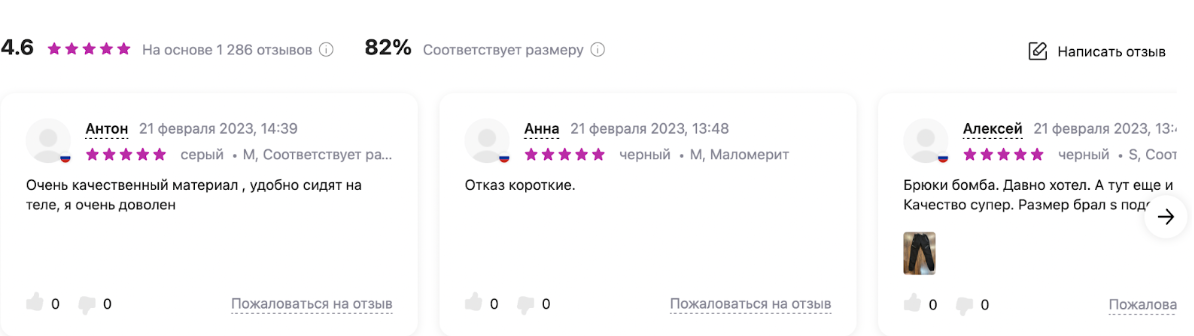
#### Задача
Необходимо разработать механизм, позволяющий определить фейковые отзывы. Фейковый отзыв — проплаченный, нечестно мотивированный отзыв с целью повлиять на рейтинг товара. 
Существует два вида таких отзывов: 
положительный отзыв написан для поставщика, который заказал себе этот отзыв; 
отрицательный отзыв написан для другого поставщика с целью снизить рейтинг товара.
#### Данные
Предоставляем список размеченных отзывов, со всей необходимой мета-информацией формате csv (пользователь, текст отзыва, оценка, является ли фейком)
#### Результат
Итогом работы должен стать набор скриптов, который позволяет по полученному на входе отзыву получить ответ, является отзыв фейковым, а также сформированная выдача для тестовых отзывов.


## <u>L0:</u> Проработка и формализация задачи, определение таргета

Задача состоит в том, чтобы определить является отзыв фейковым или нет. Это задача бинарной классификации, в качестве объектов принимаются отзывы, каждый из которых представлен множеством количественных признаков `f1`, `f2`,  ... `f8`. <b>Таргетом</b> в данной задаче является индикатор Y = {1 - если фейк, 0 - иначе}.

Таким образом, <b>результатом решения</b> должна стать модель, которая по входным данным: `f1`, `f2`, ... `f8` определяет является отзыв фейковым или нет.

## <u>L1:</u> Первичный анализ данных, очищение данных

Импортируем все необходимые модули, считаем данные и посмотрим на первые пять строк.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, fbeta_score, precision_score

from xgboost import XGBClassifier
import xgboost as xgb

from catboost import CatBoostClassifier, cv, Pool

import torch
import torch.nn as nn
from torch.autograd import Variable

torch.manual_seed(123);

In [2]:
data = pd.read_csv('wb_school_task_2.csv.gzip', compression='gzip')

In [3]:
data.head(5)

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.0,14,0,4.500000,4,6,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.0,374,30,4.772727,14,15,1
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.0,6,4,5.000000,26,33,0


Уберем ненужные для нас столбцы `id1`, `id2`, `id3`, `text` и запишем эту таблицу в новую переменную <b><i>df</i></b>.

In [4]:
df = data.drop(columns=['text'], axis=1)
df.head(5)

,id1,id2,id3,f1,f2,f3,f4,f5,f6,f7,f8,label
0,7596126584852021591,173777575861152844,18254136755182295358,1,1,1.0,11,13,4.272727,18,36,0
1,5327406586753254371,14366783259208998381,2324030737335224220,10,6,2.7,46,4,4.434783,90,109,1
2,2636757786779776109,16985421652518589249,4904562693381133981,4,4,4.0,14,0,4.500000,4,6,0
3,15432976385014516263,2629180387521298831,13541353053200353836,6,6,5.0,374,30,4.772727,14,15,1
4,11933982800034911890,14531191561111600318,9121890650636487522,19,18,5.0,6,4,5.000000,26,33,0


Посмотрим на сводную статистику по данным и на типы каждого из столбцов.

In [5]:
display(df.iloc[:, 3:].describe())
df.info()

,f1,f2,f3,f4,f5,f6,f7,f8,label
count,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000
mean,19.409862,16.216459,4.232658,808.603586,216.628562,4.453445,48.155620,94.356708,0.264169
std,35.746560,26.070112,1.179999,2509.350075,802.154201,0.619495,67.107753,329.525613,0.440960
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,2.000000,2.000000,4.076923,26.000000,6.000000,4.331071,8.000000,13.000000,0.000000
50%,8.000000,7.000000,4.764706,116.000000,26.000000,4.617978,30.000000,45.000000,0.000000
75%,23.000000,20.000000,5.000000,493.000000,110.000000,4.809556,65.000000,107.000000,1.000000
max,638.000000,550.000000,5.000000,35375.000000,15683.000000,5.000000,1058.000000,9243.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123 entries, 0 to 3122
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id1     3123 non-null   uint64 
 1   id2     3123 non-null   uint64 
 2   id3     3123 non-null   uint64 
 3   f1      3123 non-null   int64  
 4   f2      3123 non-null   int64  
 5   f3      3123 non-null   float64
 6   f4      3123 non-null   int64  
 7   f5      3123 non-null   int64  
 8   f6      3123 non-null   float64
 9   f7      3123 non-null   int64  
 10  f8      3123 non-null   int64  
 11  label   3123 non-null   int64  
dtypes: float64(2), int64(7), uint64(3)
memory usage: 292.9 KB


Как видим, все данные приведены в подходящий формат.

<b>Проверим есть ли пропуски в данных.</b>

In [6]:
df.isnull().sum()

id1      0
id2      0
id3      0
f1       0
f2       0
f3       0
f4       0
f5       0
f6       0
f7       0
f8       0
label    0
dtype: int64

Пропусков нет

Проверим дубликаты

In [7]:
df = df.drop_duplicates()

Посмотрим на соотношение фейковых и непроплаченных отзывов и на общее распределение.

In [8]:
fakes_count = df[df['label'] == 1].shape[0]
print('Количество фейковых отзывов: ', fakes_count)
print('Количество реальных отзывов: ', df.shape[0] - fakes_count)

Количество фейковых отзывов:  825
Количество реальных отзывов:  2297


In [9]:
features = df.columns[3:]

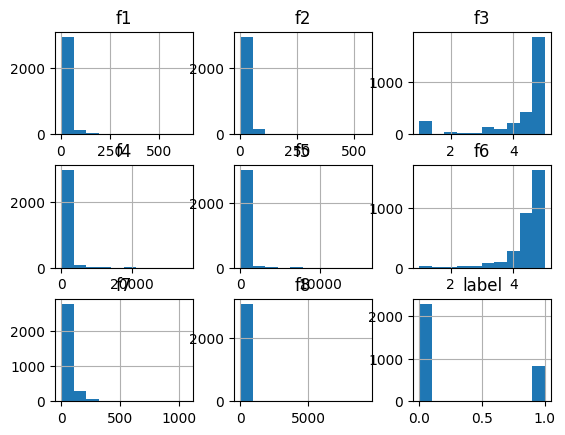

In [10]:
df[features].hist()
plt.show()

Посмотрим на матрицу корреляции через тепловую карту. 

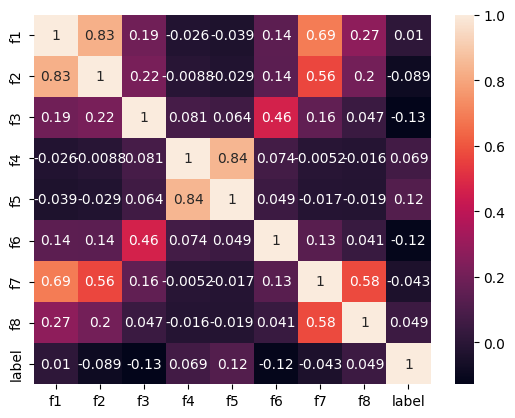

In [11]:
corr = df[features].corr()
sns.heatmap(corr, annot=True);

Можно заметить 
 * Высокую положительную корреляцию между признаками: `f1` и `f2`, `f4` и `f5`;
 * Среднюю положительную корреляцию между признаками: `f1` и `f7`, `f2` и `f7`, `f7` и `f8`;
 
Из-за сильной корреляции между признаками может возникнуть проблема мультиколлинеарности, что может привести к переоценке важности признаков и неправильному предсказанию класса. Для решения этой проблемы нужно определить какой из признаков дает более важную информацию.

Воспользуемся методом случайного леса. Он создает несколько решающих деревьев, каждое из которых использует только подмножество признаков. После построения деревьев, он определяет важность каждого признака путем оценки важности, которую дает каждый признак для уменьшения ошибок на данном дереве.

In [12]:
X, y = df.iloc[:, 3:-1].values, df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

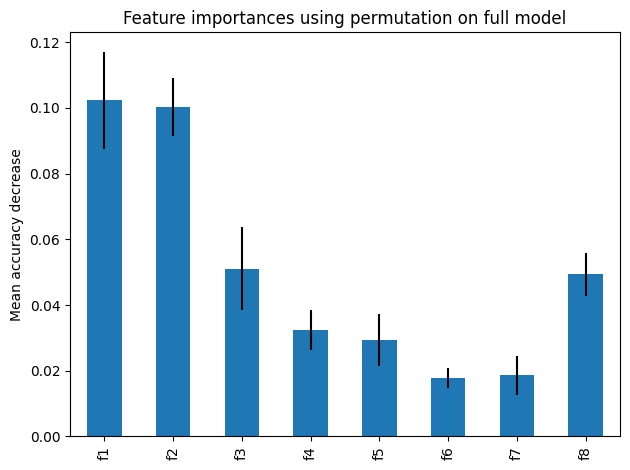

In [13]:
feature_names = [f'f{i}' for i in range(1, 9)]

forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Данный график показывает, что среди признаков стоит оставить `f1`, `f3`, `f4`, `f6`, `f7`, `f8`, однако удаление признаков может повлечь за собой еще большие ошибки.

Посмотрим на распределение каждого из признаков по категориям отзывов (для 0 и 1).

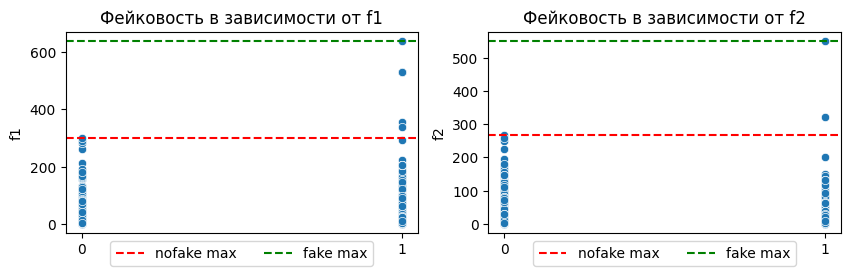

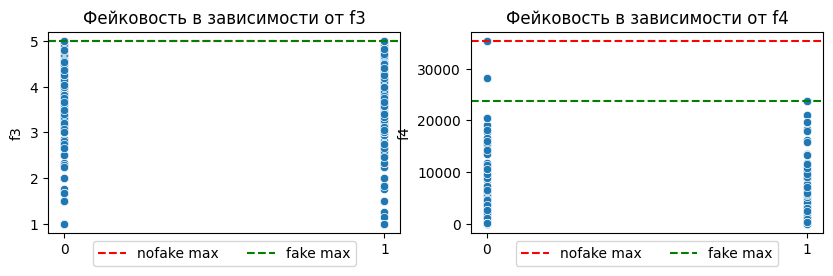

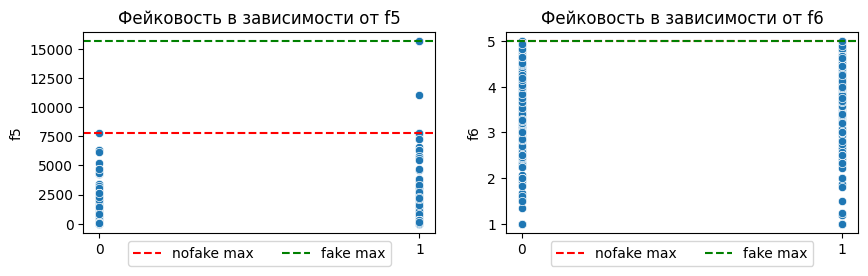

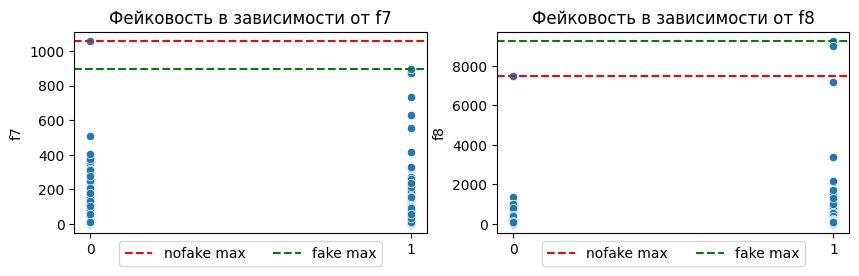

In [14]:
for i in range(1, 9, 2):
    plt.figure(figsize=(10, 12))
    
    plt.subplot(4, 2, i)
    plt.title(f'Фейковость в зависимости от f{i}')
    sns.scatterplot(y=df[f'f{i}'], x=df['label'])
    plt.axhline(y=df[df['label'] == 0][f'f{i}'].max(), color='red', linestyle='--', label='nofake max')
    plt.axhline(y=df[df['label'] == 1][f'f{i}'].max(), color='green', linestyle='--', label='fake max')
    plt.xticks([0, 1])
    plt.xlabel(None)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    
    plt.subplot(4, 2, i+1)
    plt.title(f'Фейковость в зависимости от f{i+1}')
    sns.scatterplot(y=df[f'f{i+1}'], x=df['label'])
    plt.axhline(y=df[df['label'] == 0][f'f{i+1}'].max(), color='red', linestyle='--', label='nofake max')
    plt.axhline(y=df[df['label'] == 1][f'f{i+1}'].max(), color='green', linestyle='--', label='fake max')
    plt.xticks([0, 1])
    plt.xlabel(None)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    
    plt.show()

Избавимся от значений между красной и зеленой чертами для нефейковых отзывов. Это выбросы или аномалии. Для признаков `f7` и `f8` также избавимся от значений, где f7 > 900 и f8 > 6000 (df['label'] == 0) соотвественно.

In [15]:
#df = df.drop(df[(df['label'] == 0) & (df['f4'] > 25000)].index)
#df = df.drop(df[(df['label'] == 0) & (df['f7'] > 800)].index)
#df = df.drop(df[(df['label'] == 0) & (df['f8'] > 6000)].index)

In [16]:
print(f'Итого мы удалили {data.shape[0] - df.shape[0]} значений.')

Итого мы удалили 1 значений.


## <u>L2:</u> Ресерч проблематики, определение набора подходящих решений

1. __CatBoost__ - это метод градиентного бустинга, который может автоматически обрабатывать категориальные признаки, что позволяет ему лучше работать с данными, содержащими категориальные переменные.
- Плюсы: высокая скорость работы, автоматическая обработка категориальных признаков, хорошая устойчивость к выбросам
- Минусы: требует тщательного выбора гиперпараметров, может приводить к переобучению на небольших наборах данных

2. __Neural Networks__ - это методы классификации использующие искусственные нейронные сети, включая сверточные нейронные сети (Convolutional Neural Networks - CNN) и рекуррентные нейронные сети (Recurrent Neural Networks - RNN). Они могут использоваться для классификации данных на основе последовательностей.
- Плюсы: высокая точность и универсальность, возможность использования как с числовыми, так и с другими типами признаков
- Минусы: требовательность к вычислительным ресурсам, имеет много гиперпараметров, может быть сложным в настройке, сложная интерпретация результатов

3. __Gradient Boosted Decision Trees__ - это метод принятия решений, который использует градиентный бустинг, чтобы обучать множественные деревья решений для классификации.
- Плюсы: хорошая точность, хорошая обработка числовых признаков, возможное использование на больших наборах данных
- Минусы: склонность к переобучению, требует тщательного подбора гиперпараметров

4. __Logistic Regression__ - это классический метод классификации, который может использоваться с числовыми данными.
- Плюсы: простота использования, небольшое количество гиперпараметров, легко интерпретировать результаты
- Минусы: сложно обрабатывать нелинейные зависимости между признаками, может быть неэффективным

5. __Naive Bayes classifier__ - модель, которая основовывается на предположении о том, что признаки независимы друг от друга.
- Плюсы: простота использования, высокая скорость обучения, устойчив к выбросам, работает при малых данных.
- Минусы: плохо справляется с несбалансированными данными, предположение о независимости признаков.

В статье "Spam Review Detection Using Deep Learning"<sup>1</sup> Authors: G.M.Shahariar, Swapnil Biswas, Faiza Omar, Faisal Muhammad Shah, Samiha Binte Hassan сравнивались классические методы машинного обучения с нейронными сетями. Нейронные сети показали лучшие результаты, особенно можно выделить CNN. Также стоит отметить статью "Efficient Fraud Detection Using Deep Boosting Decision Trees"<sup>2</sup> Authors: Biao Xu, Yao Wang, Xiuwu Liao, Kaidong Wang, в которой применяется 3 метод для классификации мошенничества.

__Deep Boosting Decision Trees (DBDT)__ - это алгоритм, который объединяет классические методы с нейросетевыми и эффективно справляется с несбалансированными данными. Архитектура алгоритма DBDT касается двух главных компонентов: деревьев решений и бустинга. Подход DBDT строит глубокие деревья решений и итеративно улучшает качество каждого дерева с помощью бустинга.

Алгоритм начинается с создания первого дерева решений на исходном наборе данных. Затем мы рассчитываем ошибки классификации для каждого примера и используем эти ошибки для обновления весов данных. Увеличенные веса последующих деревьев решений уделяются учету определенных ошибок, допущенных ранее на этапе классификации.

С каждым новым деревом решений, важность каждого признака определяется на основе его вклада в уменьшение ошибки. Мы строим новое дерево решений, которое уделяет большее значение наиболее релевантным признакам, и затем улучшаем качество результата при помощи бустинга. 

Конечный результат - это ансамбль деревьев решений, которые обеспечивают улучшенную точность классификации благодаря построению глубоких деревьев и их последующим усилением.

<sup>1</sup> https://arxiv.org/pdf/2211.01675.pdf

<sup>2</sup> https://arxiv.org/pdf/2302.05918.pdf

## <u>L3:</u> Формирование обучающей выборки, проектирование валидации

<u>Решение проблемы дисбаланса классов выборки:</u>

__SMOTE__

Идея метода заключается в том, чтобы увеличить малый класс за счёт представителей выпуклых комбинаций пар, для точки малого класса выбирается один из k ближайших соседей и на отрезке между ними случайно выбирается новый объект.

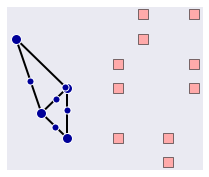

__ADASYN__

Это метод синтетического увеличения выборки, который используется для решения проблемы дисбаланса классов. Он аналогичен SMOTE, но число объектов, которые генерируются с помощью объекта малого класса, пропорционально числу чужаков (объектов большого класса) в его окрестности.

In [17]:
from imblearn.over_sampling import ADASYN, SMOTE

X, y = df[features[:-1]], df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_valid, y_valid, train_size=0.5,
                                                    stratify=y_valid, random_state=42)

adasyn = ADASYN(random_state=42)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print('Old shape: {}, fake count: {}, ratio={:.3f}'.format(
    X_train.shape[0],
    y_train.sum(),
    y_train.sum() / y_train.shape[0]
))

print('ADASYN shape: {}, fake count: {}, ratio={:.3f}'.format(
    X_train_balanced.shape[0],
    y_train_balanced.sum(),
    y_train_balanced.sum() / y_train_balanced.shape[0]
))

print('SMOTE shape: {}, fake count: {}, ratio={:.3f}'.format(
    X_train_resampled.shape[0],
    y_train_resampled.sum(),
    y_train_resampled.sum() / y_train_resampled.shape[0]
))

Old shape: 2497, fake count: 660, ratio=0.264
ADASYN shape: 3758, fake count: 1921, ratio=0.511
SMOTE shape: 3674, fake count: 1837, ratio=0.500


Для модели DBDT балансировка классов не требуется, здесь нужно только нормализовать данные.

In [18]:
X, y = df[feature_names], df['label']
x_train, x_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)
x_test, x_valid, y_test, y_valid = train_test_split(x_valid, y_valid, train_size=0.5,
                                                    stratify=y_valid, random_state=42)

x_train = (x_train - x_train.min()) / (x_train.max() - x_train.min())
x_valid = (x_valid - x_valid.min()) / (x_valid.max() - x_valid.min())
x_test = (x_test - x_test.min()) / (x_test.max() - x_test.min())

x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test = np.array(x_test)

y_train = np.array(y_train).astype(np.float32)
y_valid = np.array(y_valid).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

#y_train = y_train.reshape(-1)
#y_valid = y_valid.reshape(-1)
#y_test = y_test.reshape(-1)

y_train = y_train * 2 - 1
y_valid = y_valid * 2 - 1
y_test = y_test * 2 - 1

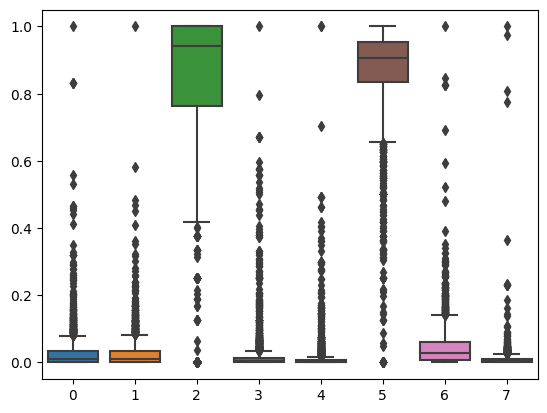

In [19]:
sns.boxplot(x_train);

## <u>L4:</u> Разработка бейзлайна и реализация выбранного решения.

### Baseline 

In [20]:
X, y = df[feature_names], df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, train_size=0.5, stratify=y_valid, random_state=42)

In [21]:
%%time

weights = (y == 0).sum() / (1.0 * (y == 1).sum()) * 1.1

param = {
    'eta': 0.08,
    'max_depth': 5,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': weights,
    'gamma': 11,
    'min_child_weight': 3,
    'alpha':30    
}

num_round = 90
dtrain = xgb.DMatrix(X_train, label=y_train)
baseline = xgb.train(param, dtrain, num_round)

valid_pred_xgb = baseline.predict(xgb.DMatrix(X_valid))
test_pred_xgb = baseline.predict(xgb.DMatrix(X_test))

print("valid_score: %.2f%%" % (roc_auc_score(y_valid, valid_pred_xgb) * 100.0))
print("test_score: %.2f%%" % (roc_auc_score(y_test, test_pred_xgb) * 100.0))
print('-' * 60)
print('Classification report:')
print(classification_report((valid_pred_xgb > 0.66).astype(int), y_valid))
print(classification_report((test_pred_xgb > 0.66).astype(int), y_test))
print('-' * 60)

valid_score: 71.29%
test_score: 73.19%
------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.75      0.86       303
           1       0.09      0.78      0.15         9

    accuracy                           0.75       312
   macro avg       0.54      0.77      0.50       312
weighted avg       0.97      0.75      0.84       312

              precision    recall  f1-score   support

           0       1.00      0.74      0.85       310
           1       0.04      1.00      0.07         3

    accuracy                           0.74       313
   macro avg       0.52      0.87      0.46       313
weighted avg       0.99      0.74      0.84       313

------------------------------------------------------------
CPU times: user 1.11 s, sys: 14.5 ms, total: 1.12 s
Wall time: 345 ms


### CatBoost 

In [22]:
X, y = df[feature_names], df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, train_size=0.5, stratify=y_valid, random_state=42)

pool = Pool(data=X_train, label=y_train)

In [23]:
%%time

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    random_seed=42,
    eval_metric='AUC',
    leaf_estimation_iterations=7
)

model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    verbose=False
)

valid_pred_catboost = model.predict(X_valid)
test_pred_catboost = model.predict(X_test)

print("valid_score: %.2f%%" % (roc_auc_score(y_valid, valid_pred_catboost) * 100.0))
print("test_score: %.2f%%" % (roc_auc_score(y_test, test_pred_catboost) * 100.0))
print('-' * 60)
print('Classification report:')
print(classification_report(y_valid, valid_pred_catboost))
print(classification_report(y_test, test_pred_catboost))
print('-' * 60)

valid_score: 56.84%
test_score: 59.37%
------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       230
           1       0.72      0.16      0.26        82

    accuracy                           0.76       312
   macro avg       0.74      0.57      0.56       312
weighted avg       0.75      0.76      0.70       312

              precision    recall  f1-score   support

           0       0.77      0.98      0.87       230
           1       0.81      0.20      0.33        83

    accuracy                           0.78       313
   macro avg       0.79      0.59      0.60       313
weighted avg       0.78      0.78      0.72       313

------------------------------------------------------------
CPU times: user 6.82 s, sys: 945 ms, total: 7.76 s
Wall time: 2.15 s


In [24]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,f1,16.206060
1,f2,13.570226
2,f7,12.486587
3,f3,12.445073
4,f5,12.316716
5,f8,11.610162
6,f4,11.592463
7,f6,9.772713


Данный метод позволяет узнать, какие именно признаки в данной модели привносят больший влклад в прогноз. Таким образом в данной модели признак f1 имеет наибольший вклад, а f6 - наименьший.

### Deep Boosting Decision Trees (DBDT) 

В гугл коллабе по ссылке можно найти обучение модели, а так же переобучить ее с другими данными или другими параметрами. Так же есть сохранение весов для дальнейшего использования. Для этого нужно описать класс и можно предсказывать. Обучение на 80 эпохах заняло примерно 5 минут.

https://colab.research.google.com/drive/1_nGpL8BLyHjfJXbr4ro9UrKLYj1eb7fU?authuser=1&hl=ru#scrollTo=neMyrXQk1Wqc

In [25]:
class SDTs(nn.Module):
    def __init__(
            self,
            n_x, # Кол-во входных данных
            tree_levels=3, # Глубина дерева
            lmbd=0.1, # Коэффициент регуляризации 
            T=100, # Кол-во итераций
            imratio=None,
            random_seed=4,
            margin=1,
            backend='ce',
            use_cuda=True):
        torch.manual_seed(random_seed)
        super(SDTs, self).__init__()
        self.tree_levels = tree_levels
        self.leafs_numb = 2 ** (self.tree_levels - 1)
        self.inner_numb = self.leafs_numb - 1
        self.lmbd = lmbd
        self.device = torch.device("cuda" if use_cuda else "cpu")
        self.T = T
        self.margin = margin
        self.p = imratio
        self.a = torch.zeros(1, dtype=torch.float32, device=self.device, requires_grad=True).to(self.device)
        self.b = torch.zeros(1, dtype=torch.float32, device=self.device, requires_grad=True).to(self.device)
        self.alpha = torch.zeros(1, dtype=torch.float32, device=self.device, requires_grad=True).to(self.device)
        self.backend = 'ce'  # TODO:

        self.V_next_value = torch.zeros([self.inner_numb, self.T])

        self.param_dict = {}
        for i in range(T):
            self.param_dict['W' + str(i)] = nn.Parameter(
                torch.nn.init.xavier_uniform_(Variable(torch.randn(n_x, self.inner_numb)), gain=1))
            self.param_dict['b' + str(i)] = nn.Parameter(
                torch.nn.init.constant_(Variable(torch.randn(1, self.inner_numb)), 0))
            self.param_dict['phi' + str(i)] = nn.Parameter(
                torch.nn.init.xavier_uniform_(Variable(torch.randn(self.leafs_numb, 1), ), gain=1))

        self.params = self.param_dict.values()

    # Функции для реализации итерабельности по параметрам модели
    def __iter__(self):
        return iter(self.params)

    def __len__(self):
        return len(self.params)

    def __getitem__(self, idx):
        return self.params[idx]

    def node_probability(self, index_node, A):
        p = torch.ones(A.shape[0])
        while index_node - 1 >= 0:
            father_index = int((index_node - 1) / 2)
            if (index_node - 1) % 2 == 0:
                p = p * (1.0 - A[:, father_index])
            else:
                p = p * (A[:, father_index])
            index_node = father_index
        return p

    # Прямой проход
    def forward_propagation_Boosting(self, X, W, b):
        Z = torch.add(torch.matmul(X, W), b)
        A = torch.sigmoid(1 * Z)
        return A
    
    # Вероятность принадлежности входных данных к листовому узлу
    def compute_leafs_prob_matrix(self, A):
        ta = list()
        i = 0
        while i < self.leafs_numb:
            ta.append(self.node_probability(self.leafs_numb - 1 + i, A))
            i = i + 1
        leafs_prob_matrix = torch.stack(ta, dim=0)
        return leafs_prob_matrix

    # Вероятность активации каждого внутреннего узла
    def compute_inner_prob_matrix(self, A):
        ta = list()
        i = 0
        while i < self.inner_numb:
            ta.append(self.node_probability(i, A))
            i = i + 1
        inner_prob_matrix = torch.stack(ta, dim=0)
        return inner_prob_matrix

    # Регуляризационный показатель функции потерь
    def compute_regularization(self, A, inner_prob_matrix, V_prec):
        ta = list()
        ema = list()
        i = 0
        while i < self.inner_numb:
            depth = int(np.log(i + 1) / np.log(2))
            decay = 1. - np.exp(-depth)
            a_i = torch.div(torch.matmul(inner_prob_matrix[i, :], A[:, i]), torch.sum(inner_prob_matrix[i, :]))
            w_i = decay * V_prec[i] + (1. - decay) * a_i
            r_i = -self.lmbd * (2 ** (-depth)) * (
                    0.5 * torch.log(w_i) + 0.5 * torch.log(1.0 - w_i))
            ta.append(r_i)
            ema.append(w_i)
            i = i + 1
        regularization = torch.sum(torch.stack(ta, dim=0))
        V_next = torch.stack(ema, dim=0)
        return regularization, V_next

    # Вывод модели SDTs, объединяя прогнозы каждого дерева в лесу
    def compute_Boosting_output(self, X, Y):
        X = X.float()
        output_sum = torch.full_like(Y, Y.mean())
        output = []

        for t in range(self.T):
            A = self.forward_propagation_Boosting(X, self.param_dict['W' + str(t)], self.param_dict['b' + str(t)])
            leafs_prob_matrix = self.compute_leafs_prob_matrix(A)
            inner_prob_matrix = self.compute_inner_prob_matrix(A)
            output.append(torch.matmul(leafs_prob_matrix.permute(1, 0), self.param_dict['phi' + str(t)]))
            output_sum = output_sum + 0.1 * torch.squeeze(output[t])
        return output_sum

    # Метод для вычисления функции потерь
    def compute_cost_Boosting_wr(self, X, Y):
        output_sum = torch.full_like(Y, Y.mean())
        output = []
        V_next = []
        cost_sum = torch.tensor(0)
        Y = Y.reshape(-1)
        for t in range(self.T):
            A = self.forward_propagation_Boosting(X, self.param_dict['W' + str(t)], self.param_dict['b' + str(t)])
            leafs_prob_matrix = self.compute_leafs_prob_matrix(A)
            inner_prob_matrix = self.compute_inner_prob_matrix(A)
            output.append(torch.matmul(leafs_prob_matrix.permute(1, 0), self.param_dict['phi' + str(t)]))
            output_sum = output_sum + 0.1 * torch.squeeze(output[t])
            loss_Boosting = torch.exp(-torch.mul(output_sum, Y))
            residual = torch.mul(loss_Boosting, Y)
            cost_wr = torch.sum(torch.pow((residual - torch.squeeze(output[t])), 2))
            reg, V_now = self.compute_regularization(A, inner_prob_matrix, self.V_next_value[:, t])
            V_next.append(V_now)
            cost_sum = cost_sum + cost_wr + 1. * reg + 0.005 * torch.sum(torch.pow(self.param_dict['W' + str(t)], 2))
        V_next = torch.stack(V_next, 1)
        self.V_next_value = V_next.detach()
        
        return cost_sum

In [26]:
# Data Preprocessing
X, y = df[feature_names], df['label']
x_train, x_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, train_size=0.5, stratify=y_valid, random_state=42)

x_train = (x_train - x_train.min()) / (x_train.max() - x_train.min())
x_valid = (x_valid - x_valid.min()) / (x_valid.max() - x_valid.min())
x_test = (x_test - x_test.min()) / (x_test.max() - x_test.min())

x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test = np.array(x_test)

y_train = np.array(y_train).astype(np.float32)
y_valid = np.array(y_valid).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

y_train = y_train.reshape(-1)
y_valid = y_valid.reshape(-1)
y_test = y_test.reshape(-1)

y_train = y_train * 2 - 1
y_valid = y_valid * 2 - 1
y_test = y_test * 2 - 1

In [27]:
%%time

n_x = x_valid.shape[1]
dbdt = SDTs(n_x, use_cuda=False, random_seed=0)
dbdt.params = torch.load('model_adam.pth', map_location=torch.device('cpu')).values()

valid_pred_dbdt = dbdt.compute_Boosting_output(torch.tensor(x_valid), torch.tensor(y_valid))
valid_pred_dbdt = np.array(torch.Tensor.tolist(valid_pred_dbdt))

test_pred_dbdt = dbdt.compute_Boosting_output(torch.tensor(x_test), torch.tensor(y_test))
test_pred_dbdt = np.array(torch.Tensor.tolist(test_pred_dbdt))

print("valid_score: %.2f%%" % (roc_auc_score(np.array(y_valid == 1).astype(int), valid_pred_dbdt) * 100.0))

print("test_score: %.2f%%" % (roc_auc_score(np.array(y_test == 1).astype(int), test_pred_dbdt) * 100.0))

print('-' * 60)
print('Classification report:')
print(classification_report(np.array(y_valid == 1).astype(int), np.array(valid_pred_dbdt > -0.711).astype(int)))
print(classification_report(np.array(y_test == 1).astype(int), np.array(test_pred_dbdt > -0.711).astype(int)))
print('-' * 60)

valid_score: 71.80%
test_score: 67.83%
------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       230
           1       0.75      0.04      0.07        82

    accuracy                           0.74       312
   macro avg       0.75      0.52      0.46       312
weighted avg       0.75      0.74      0.65       312

              precision    recall  f1-score   support

           0       0.75      1.00      0.86       230
           1       0.88      0.08      0.15        83

    accuracy                           0.75       313
   macro avg       0.81      0.54      0.50       313
weighted avg       0.78      0.75      0.67       313

------------------------------------------------------------
CPU times: user 133 ms, sys: 185 µs, total: 133 ms
Wall time: 149 ms


## <u>L5:</u> Оценка решения, оптимизация алгоритма.

In [28]:
print('AUC:')
print("baseline: %.2f%%" % (roc_auc_score((y_test + 1) / 2, test_pred_xgb) * 100))
print("catboost: %.2f%%" % (roc_auc_score((y_test + 1) / 2, test_pred_catboost) * 100))
print("dbdt:     %.2f%%" % (roc_auc_score((y_test + 1) / 2, test_pred_dbdt) * 100))

print('-' * 30)

print('F1:')
print("baseline: %.2f%%" % (f1_score((y_test + 1) / 2, (test_pred_xgb > 0.66).astype(int)) * 100))
print("catboost: %.2f%%" % (f1_score((y_test + 1) / 2, test_pred_catboost) * 100))
print("dbdt:     %.2f%%" % (f1_score((y_test + 1) / 2, (test_pred_dbdt > -0.711).astype(int)) * 100))

print('-' * 30)

print('F1-beta:')
print("baseline: %.2f%%" % (fbeta_score((y_test + 1) / 2, (test_pred_xgb > 0.66).astype(int), beta=0.7) * 100))
print("catboost: %.2f%%" % (fbeta_score((y_test + 1) / 2, test_pred_catboost, beta=0.7) * 100))
print("dbdt:     %.2f%%" % (fbeta_score((y_test + 1) / 2, (test_pred_dbdt > -0.711).astype(int), beta=0.6) * 100))

AUC:
baseline: 73.19%
catboost: 59.37%
dbdt:     67.83%
------------------------------
F1:
baseline: 6.98%
catboost: 32.69%
dbdt:     15.38%
------------------------------
F1-beta:
baseline: 10.24%
catboost: 41.07%
dbdt:     25.13%


Для начала посмотрим на данные, где модели Catboost и DBDT делают ошибки. Для этого пройдем через все данные и построчно будем делать прогноз и сравнивать с ответом. Индексы строк будем записывать в соответсвующий список.

In [29]:
%%time
not_predicted_catboost = list()
for i in range(X_test.shape[0]):
    pred = model.predict(X_test.iloc[i])
    if pred != (y_test[i] + 1) / 2:
        not_predicted_catboost.append(X_test.index[i])

CPU times: user 369 ms, sys: 57.9 ms, total: 427 ms
Wall time: 229 ms


In [30]:
%%time
not_predicted_dbdt = list()

y_ = np.array([0]* 2).astype(np.float32)
y_ = y_ * 2 - 1

for i in range(X_test.shape[0]):
    X, y = x_test[i], y_test[i]
    X = np.array([list(X), list(X)])

    X = X * 2 - 1

    pred = dbdt.compute_Boosting_output(torch.tensor(X), torch.tensor(y_))
    pred = np.array(torch.Tensor.tolist(pred))
    pred = (pred > -0.711).astype(int)
    y = (y == 1).astype(int)
    
    if pred[0] != y:
        not_predicted_dbdt.append(X_test.index[i])

CPU times: user 16.6 s, sys: 0 ns, total: 16.6 s
Wall time: 16.6 s


Тепреь посмотрим на распределения неверных предсказаний для моделей Catboost и DBDT по каждому из признаков.

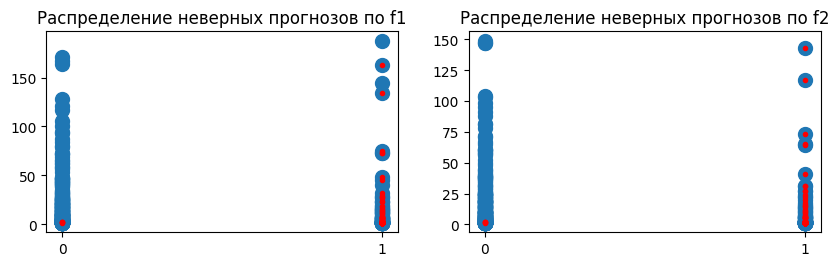

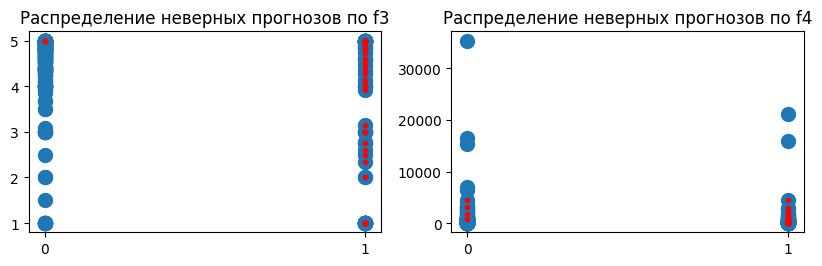

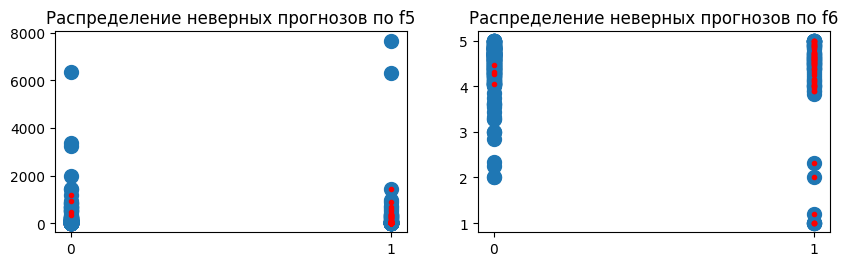

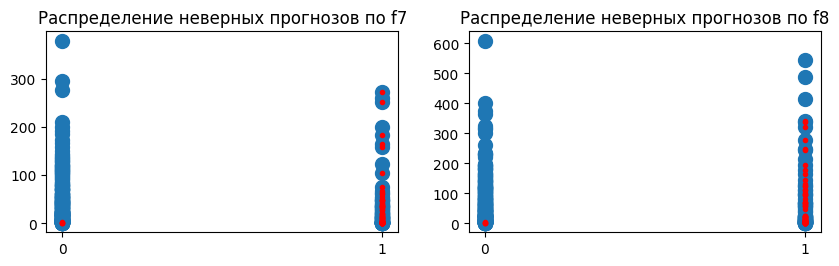

In [31]:
# Catboost
df_ = data.iloc[not_predicted_catboost, 4:]
for i in range(1, 9, 2):
    plt.figure(figsize=(10, 12))
    
    plt.subplot(4, 2, i)
    plt.title(f'Распределение неверных прогнозов по f{i}')
    plt.scatter(y=data.iloc[X_test.index][f'f{i}'], x=data.iloc[X_test.index]['label'], s=100)
    plt.scatter(y=df_[f'f{i}'], x=df_['label'], color='red', marker='.')
    plt.xticks([0, 1])
    
    plt.subplot(4, 2, i+1)
    plt.title(f'Распределение неверных прогнозов по f{i+1}')
    plt.scatter(y=data.iloc[X_test.index][f'f{i+1}'], x=data.iloc[X_test.index]['label'], s=100)
    plt.scatter(y=df_[f'f{i+1}'], x=df_['label'], color='red', marker='.')
    plt.xticks([0, 1])
    
    plt.show()

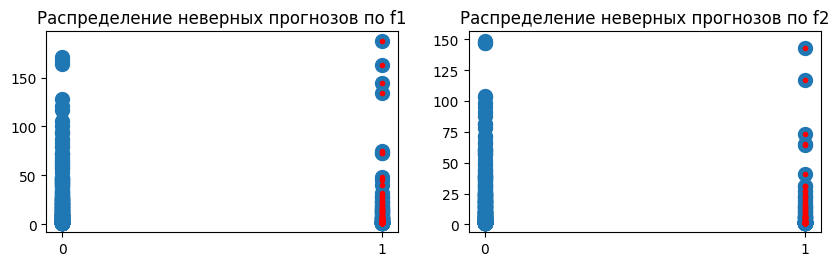

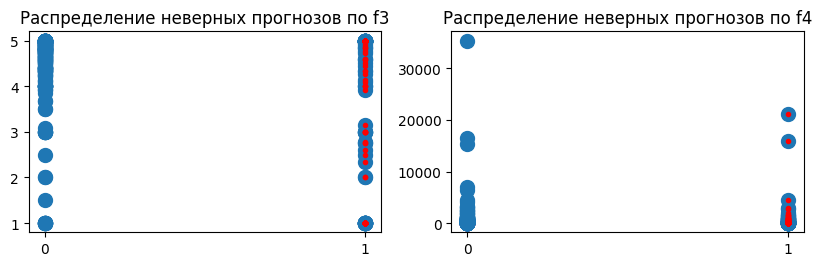

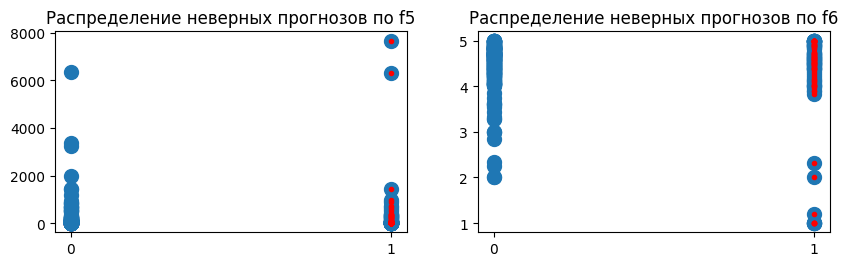

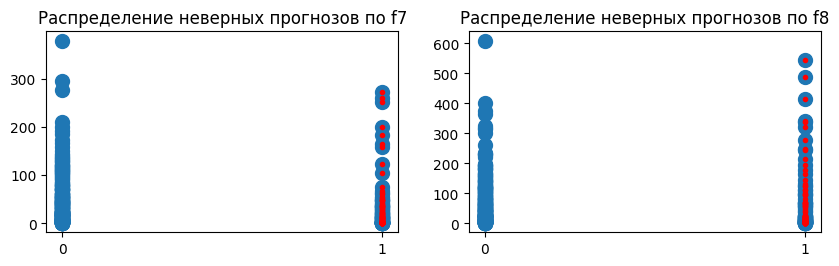

In [32]:
# DBDT
df_ = data.iloc[not_predicted_dbdt, 4:]
for i in range(1, 9, 2):
    plt.figure(figsize=(10, 12))
    
    plt.subplot(4, 2, i)
    plt.title(f'Распределение неверных прогнозов по f{i}')
    plt.scatter(y=data.iloc[X_test.index][f'f{i}'], x=data.iloc[X_test.index]['label'], s=100)
    plt.scatter(y=df_[f'f{i}'], x=df_['label'], color='red', marker='.')
    plt.xticks([0, 1])
    
    plt.subplot(4, 2, i+1)
    plt.title(f'Распределение неверных прогнозов по f{i+1}')
    plt.scatter(y=data.iloc[X_test.index][f'f{i+1}'], x=data.iloc[X_test.index]['label'], s=100)
    plt.scatter(y=df_[f'f{i+1}'], x=df_['label'], color='red', marker='.')
    plt.xticks([0, 1])
    
    plt.show()

Как видим, модель Catboost немного ошибается в классе 0, однако большинство ошибок приходится на класс 1. В то время, как модель DBDT ошибается только в классе 1.

Модель Catboost ошибается при больших значениях признаков f3, f6 (оценках) и слишком маленьких. Также ошибается при малых значениях остальных признаков для класса 0.

Модель DBDT с трудом предсказывает класс 1, однако делает это точно.

Так как baseline и DBDT имеют precision = 1 для класса 0, то их можно объединить тем самым увеличив кол-во верных предсказаний. Также идея добавить и прогноз Catboost'а, модель будет немного ошибаться на нулевом классе, однако добавятся и прогнозы класса 1.

#### Объединение моделей 

Посмотрим на метрики у новой модели

In [33]:
# Отчет по объединению

valid_pred_catboost = model.predict_proba(X_valid)[:, 1]
test_pred_catboost = model.predict_proba(X_test)[:, 1]

valid_pred_com = (valid_pred_xgb + valid_pred_catboost + valid_pred_dbdt + 1)/3
test_pred_com = (test_pred_xgb + test_pred_catboost + test_pred_dbdt+1) / 3

print('AUC:')
print("valid_score: %.2f%%" % (roc_auc_score((y_valid==1).astype(int), valid_pred_com) * 100))

print("test_score: %.2f%%" % (roc_auc_score((y_test==1).astype(int), test_pred_com) * 100))

print('-' * 60)

print('F1:')
print("valid_score: %.2f%%" % (f1_score((y_valid==1).astype(int), (valid_pred_com>0.3611).astype(int)) * 100))
print("test_score: %.2f%%" % (f1_score((y_test==1).astype(int), (test_pred_com>0.3611).astype(int)) * 100))

print('-' * 60)

print('F1-beta:')
print("valid_score: %.2f%%" % (fbeta_score((y_valid==1).astype(int), (valid_pred_com>0.3611).astype(int), beta=0.7) * 100))
print("test_score: %.2f%%" % (fbeta_score((y_test==1).astype(int), (test_pred_com>0.3611).astype(int), beta=0.7) * 100))

print('-' * 60)

print(classification_report((y_valid==1).astype(int), (valid_pred_com >0.3611).astype(int)))

print(classification_report((y_test==1).astype(int), (test_pred_com > 0.3611).astype(int)))

AUC:
valid_score: 75.60%
test_score: 78.12%
------------------------------------------------------------
F1:
valid_score: 52.63%
test_score: 60.64%
------------------------------------------------------------
F1-beta:
valid_score: 51.90%
test_score: 58.30%
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       230
           1       0.51      0.55      0.53        82

    accuracy                           0.74       312
   macro avg       0.67      0.68      0.67       312
weighted avg       0.75      0.74      0.74       312

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       230
           1       0.54      0.69      0.61        83

    accuracy                           0.76       313
   macro avg       0.71      0.74      0.72       313
weighted avg       0.79      0.76      0.77       313



In [34]:
# function predict class by f1..f8 1d-array
def predict(X, use_catboost=True):
    # Preprocessing for xgb model
    d = dict()
    for i in range(8):
        d[f'f{i+1}'] = X[i]
    X_xgb = pd.DataFrame(d, index=range(1))

    # Preprocessing for dbdt model
    y_ = np.array([0] * 2)
    y_ = y_ * 2 - 1
    X_ = np.array([list(X), list(X)])
    X_ = (X_ - X_.min()) / (X_.max() - X_.min())
    X_ = np.array(X_).astype(np.float32)
    y_ = np.array(y_).astype(np.float32)

    X = X * 2 - 1

    xgb_pred = baseline.predict(xgb.DMatrix(X_xgb))[0]
    catboost_pred = model.predict_proba(X)[1]
    dbdt_pred = dbdt.compute_Boosting_output(torch.tensor(X_), torch.tensor(y_))
    dbdt_pred = np.array(torch.Tensor.tolist(dbdt_pred))[0]
    
    pred = (xgb_pred + catboost_pred + dbdt_pred + 1) / 3
    return (pred > 0.3611).astype(int)

Посмотрим, где ошибается новая модель

In [35]:
%%time
not_predicted_test = list()
for i in range(X_test.shape[0]):
    if predict(X_test.iloc[i].values) != int((y_test[i] + 1) / 2):
        not_predicted_test.append(X_test.index[i])

CPU times: user 35.3 s, sys: 216 ms, total: 35.5 s
Wall time: 18.6 s


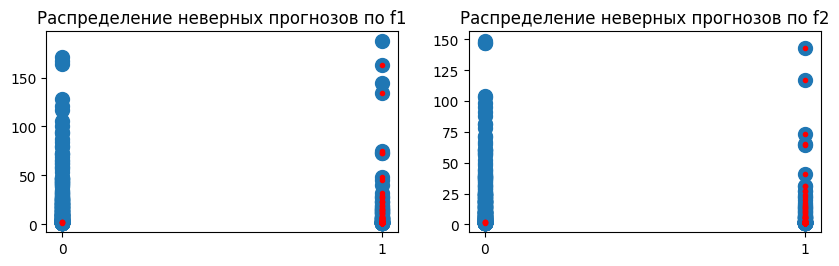

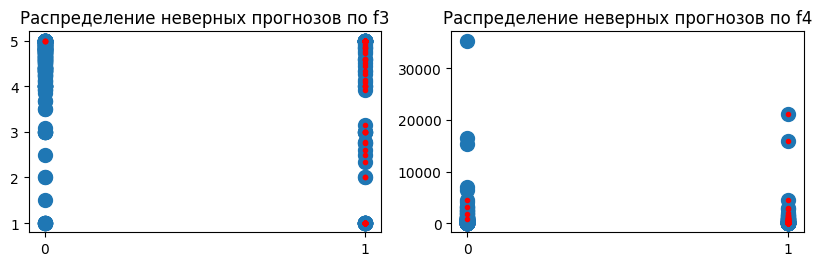

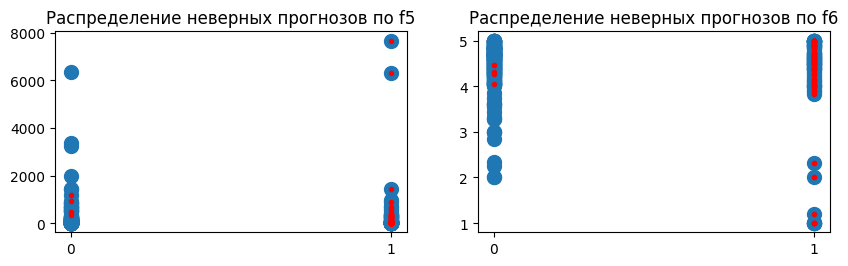

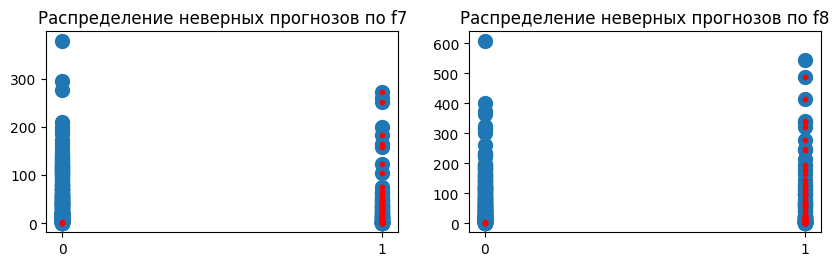

In [36]:
df_ = data.iloc[not_predicted_test, 4:]
for i in range(1, 9, 2):
    plt.figure(figsize=(10, 12))
    
    plt.subplot(4, 2, i)
    plt.title(f'Распределение неверных прогнозов по f{i}')
    plt.scatter(y=data.iloc[X_test.index][f'f{i}'], x=data.iloc[X_test.index]['label'], s=100)
    plt.scatter(y=df_[f'f{i}'], x=df_['label'], color='red', marker='.')
    plt.xticks([0, 1])
    
    plt.subplot(4, 2, i+1)
    plt.title(f'Распределение неверных прогнозов по f{i+1}')
    plt.scatter(y=data.iloc[X_test.index][f'f{i+1}'], x=data.iloc[X_test.index]['label'], s=100)
    plt.scatter(y=df_[f'f{i+1}'], x=df_['label'], color='red', marker='.')
    plt.xticks([0, 1])
    
    plt.show()

In [37]:
loss0 = data.iloc[not_predicted_test]['label'].shape[0] - data.iloc[not_predicted_test]['label'].sum()
loss1 = data.iloc[not_predicted_test]['label'].sum()

print(f'Кол-во неверных предсказаний нулевого класса: {loss0}, ({round(loss0/X_test.shape[0] * 100, 2)}%)')
print(f'Кол-во неверных предсказаний первого класса: {loss1}, ({round(loss1/X_test.shape[0] * 100, 2)}%)')

Кол-во неверных предсказаний нулевого класса: 4, (1.28%)
Кол-во неверных предсказаний первого класса: 76, (24.28%)


Как видим, ошибок в 1 классе стало меньше, однако добавились незначительные ошибки в классе 0 (1.28% от общего количества). Метрика AUC стала больше, это более рискованное, но более результативное решение.